# Notebook to convert latitude and longitude to pair with specific districts and PSA

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Shots_psa_train = 2014-2017 of shot spotter database
shots_psa_train = pd.read_csv('./assets/mpd/shots_train_preprocessed.csv')
# Shots_psa_test  = 2018 of shot spotter database
shots_psa_test  = pd.read_csv('./assets/mpd/shots_test.csv')
# geocoordinates of the psa of Washington DC
psa = gpd.read_file('./assets/Police_Service_Areas.geojson')

In [3]:
# convert to polygram for geo spatial tracking.
def geo_(df):
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    # no longer need Longitude and latitude
    df.drop(['Longitude', 'Latitude'], axis=1, inplace=True)
    # create a coordinate system to create a better plot.
    crs = {'init': 'epsg:4326'}
    # using geopandas to match up our geometry with our coordinate system.
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)
    return df

shots_psa_train = geo_(shots_psa_train)
shots_psa_test  = geo_(shots_psa_test)

In [4]:
# set psa to only be PSA and geometry
psa = psa[['PSA','geometry']]

In [5]:
# verify all PSA are represented.
psa.PSA.nunique()

56

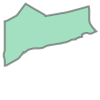

In [6]:
# it looks like a PSA to me
# change the indexed number to have fun and see the different PSA show.
psa['geometry'][2]

In [7]:
# combine the psa dataframe with our shot spotter information.
# using left join to ensure we keep our train and test data
shots_psa_train = gpd.sjoin(shots_psa_train, psa, how='left', op='within')
shots_psa_test = gpd.sjoin(shots_psa_test, psa, how='left', op='within')

In [8]:
# merge successful
shots_psa_test.head()

,ID,Type,Date,Time,Source,geometry,index_right,PSA
0,5D82955,Multiple_Gunshots,2018-01-01,00:00:03,WashingtonDC5D,POINT (-76.983 38.923),33.0,505.0
1,3D68514,Multiple_Gunshots,2018-01-01,00:00:12,WashingtonDC3D,POINT (-77.01600000000001 38.92),37.0,306.0
2,7D257817,Multiple_Gunshots,2018-01-01,00:00:14,WashingtonDC7D,POINT (-77.00399999999999 38.837),3.0,707.0
3,3D68515,Multiple_Gunshots,2018-01-01,00:00:22,WashingtonDC3D,POINT (-77.01600000000001 38.919),37.0,306.0
4,4D66770,Multiple_Gunshots,2018-01-01,00:00:46,WashingtonDC4D,POINT (-77.02500000000001 38.956),50.0,403.0


In [9]:
# Setting up the dataframe to have only the key features.  Keeping type, Date, PSA and index to keep it unique
def psa_process(df):
    df.reset_index(inplace=True)
    df.drop(['geometry', 'Source', 'Time', 'index_right', 'ID', 'index'], axis=1, inplace=True)
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)
    df = pd.get_dummies(df, columns=['Type'], drop_first=True)
    return df

shots_psa_train = psa_process(shots_psa_train)
shots_psa_test  = psa_process(shots_psa_test)

In [10]:
# After a lot of review, the null values are not in Washington DC so we will drop them.
shots_psa_train.PSA.isnull().sum(), shots_psa_test.PSA.isnull().sum()

(907, 1)

In [11]:
# Remove the shots taken place outside of Washington DC.  
def psa_process(df):
    df.dropna(inplace=True)
    df = df.astype(int) # convert to int to remove the .0
    df = df.astype(str) # convert to str to make it comparable
    return df

shots_psa_train = psa_process(shots_psa_train)
shots_psa_test  = psa_process(shots_psa_test)

In [12]:
# Save our work to new csv for easier use in future notebooks.
# shots_psa_train.to_csv('./assets/mpd/shots_train_psa.csv')
# shots_psa_test.to_csv('./assets/mpd/shots_test_psa.csv')

## Pull in data to be merged for predictions

In [14]:
shots_train = pd.read_csv('./assets/mpd/shots_train_psa.csv')
shots_test  = pd.read_csv('./assets/mpd/shots_test_psa.csv')
homes = pd.read_csv('./assets/homes/housing_data_psa.csv', index_col='Unnamed: 0')
csr_train = pd.read_pickle('./assets/csr/csr_train_EDAed.pkl')
csr_test  = pd.read_pickle('./assets/csr/csr_test_EDAed.pkl')

In [15]:
# convert information to datetime
shots_train.Date = pd.to_datetime(shots_train.Date)
shots_test.Date  = pd.to_datetime(shots_test.Date)
shots_train.head()

,Date,PSA,Type_Multiple_Gunshots,Type_Single_Gunshot
0,2014-01-01,501,1,0
1,2014-01-01,502,1,0
2,2014-01-01,505,1,0
3,2014-01-01,708,1,0
4,2014-01-01,107,1,0


In [16]:
# lower case columns so that we are using similar information across all df
def lower_columns(df):
    df.columns = map(str.lower, df.columns)
    return df

shots_train = lower_columns(shots_train)
shots_test  = lower_columns(shots_test)
homes = lower_columns(homes)
csr_train = lower_columns(csr_train)
csr_test  = lower_columns(csr_test)

In [17]:
# since the information is sparse throughout each PSA, convert to Districts
def district(df):
    df['district'] = df.psa.map(lambda x: str(x)[0])
    df.drop('psa', axis=1, inplace=True)
    return df

shots_train_district = district(shots_train)
shots_test_district  = district(shots_test)
homes_district = district(homes)
csr_train_district = district(csr_train)
csr_test_district  = district(csr_test)

In [18]:
# groupby our information to see how many shots are happening in each district on a specific date.
def grouping(df):
    df = df.groupby(['district', 'date'])\
                    [['type_multiple_gunshots', 'type_single_gunshot']].agg('sum')
    df = df.reset_index()
    df = df.set_index('date')
    return df

shots_test_district = grouping(shots_test_district)
shots_train_district = grouping(shots_train_district)

In [19]:
# Critical to fill in all the missing dates where there were no shots per each district.  
idx_train = pd.date_range('2014-01-01', '2017-12-31')

shots_train_district1 = shots_train_district[shots_train_district['district'] == '1'].reindex(idx_train, fill_value=0)
shots_train_district1.district = 1
shots_train_district2 = shots_train_district[shots_train_district['district'] == '2'].reindex(idx_train, fill_value=0)
shots_train_district2.district = 2
shots_train_district3 = shots_train_district[shots_train_district['district'] == '3'].reindex(idx_train, fill_value=0)
shots_train_district3.district = 3
shots_train_district4 = shots_train_district[shots_train_district['district'] == '4'].reindex(idx_train, fill_value=0)
shots_train_district4.district = 4
shots_train_district5 = shots_train_district[shots_train_district['district'] == '5'].reindex(idx_train, fill_value=0)
shots_train_district5.district = 5
shots_train_district6 = shots_train_district[shots_train_district['district'] == '6'].reindex(idx_train, fill_value=0)
shots_train_district6.district = 6
shots_train_district7 = shots_train_district[shots_train_district['district'] == '7'].reindex(idx_train, fill_value=0)
shots_train_district7.district = 7

shots_train_district = pd.concat((shots_train_district1, 
                            shots_train_district2, 
                            shots_train_district3, 
                            shots_train_district4, 
                            shots_train_district5, 
                            shots_train_district6, 
                            shots_train_district7))

# range is only the first quarter of 2018.
idx = pd.date_range('2018-01-01', '2018-03-31')

shots_test_district1 = shots_test_district[shots_test_district['district'] == '1'].reindex(idx, fill_value=0)
shots_test_district1.district = 1
shots_test_district2 = shots_test_district[shots_test_district['district'] == '2'].reindex(idx, fill_value=0)
shots_test_district2.district = 2
shots_test_district3 = shots_test_district[shots_test_district['district'] == '3'].reindex(idx, fill_value=0)
shots_test_district3.district = 3
shots_test_district4 = shots_test_district[shots_test_district['district'] == '4'].reindex(idx, fill_value=0)
shots_test_district4.district = 4
shots_test_district5 = shots_test_district[shots_test_district['district'] == '5'].reindex(idx, fill_value=0)
shots_test_district5.district = 5
shots_test_district6 = shots_test_district[shots_test_district['district'] == '6'].reindex(idx, fill_value=0)
shots_test_district6.district = 6
shots_test_district7 = shots_test_district[shots_test_district['district'] == '7'].reindex(idx, fill_value=0)
shots_test_district7.district = 7

shots_test_district = pd.concat((shots_test_district1, 
                            shots_test_district2, 
                            shots_test_district3, 
                            shots_test_district4, 
                            shots_test_district5, 
                            shots_test_district6, 
                            shots_test_district7))

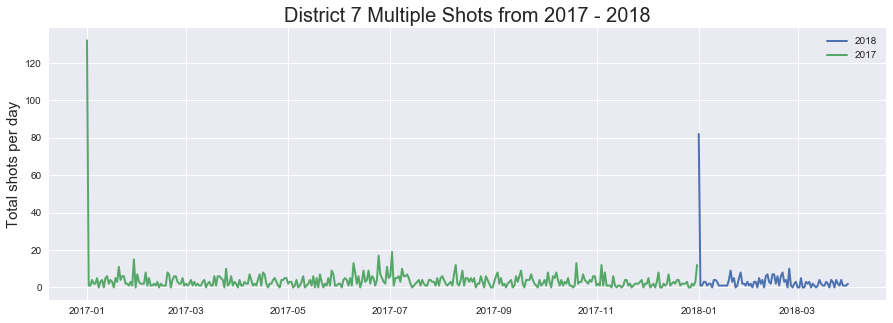

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(shots_test_district7.type_multiple_gunshots['2018'], label='2018', lw=2)
plt.plot(shots_train_district7.type_multiple_gunshots['2017'], label='2017', lw=2)
plt.title('District 7 Multiple Shots from 2017 - 2018', size=20)
plt.ylabel('Total shots per day', size=15)
plt.legend();

In [21]:
# adjust some information that was kept in the EDA notebook that is no longer needed.
csr_train_district.drop(['serviceorderstatus', 'status_code', 'priority'], axis=1, inplace=True)
csr_test_district.drop(['serviceorderstatus', 'status_code', 'priority'], axis=1, inplace=True)

# rename adddate to date so that it can merge successfully with other data frames.
csr_train_district.rename(columns={'adddate': 'date'}, inplace=True)
csr_test_district.rename(columns={'adddate': 'date'}, inplace=True)

In [22]:
csr_train_district.head(2)

,date,resolved,turnover,svc_descr_collection,svc_descr_graffiti removal,svc_descr_light repair,svc_descr_maintenance,svc_descr_parking meter repair,svc_descr_street cleaning,district
0,2014-01-02 13:27:40,1,306.0,0,0,0,0,0,1,5
1,2014-01-02 13:46:57,1,94.0,1,0,0,0,0,0,5


In [23]:
csr_train_district.date = pd.DatetimeIndex(csr_train_district.date).normalize()
csr_test_district.date  = pd.DatetimeIndex(csr_test_district.date).normalize()

In [24]:
# groupby sum of occurances and the average of time it takes to work on the 311 calls
def csr_group(df):
    csr_sum = df.groupby(['district', 'date']) \
          ['resolved', 'svc_descr_collection',
           'svc_descr_graffiti removal', 'svc_descr_light repair',
           'svc_descr_maintenance', 'svc_descr_parking meter repair',
           'svc_descr_street cleaning'].agg('sum')
    # average time over in each day to see how long in each district on each day it takes to work on 311 calls
    csr_turnover = df.groupby(['district', 'date'])[['turnover']].agg('mean')
    # reset index to allow for easier merging
    csr_sum = csr_sum.reset_index()
    csr_turnover = csr_turnover.reset_index()
    df = pd.merge(csr_turnover, csr_sum)
    return df

csr_train_district = csr_group(csr_train_district)
csr_test_district = csr_group(csr_test_district)

In [25]:
# date lost it's name earlier.  Reseting for proper merge.
shots_train_district = shots_train_district.reset_index().rename(columns={'index': 'date'})
shots_test_district  = shots_test_district.reset_index().rename(columns={'index': 'date'})

# matching district type for proper merge.
shots_train_district.district = shots_train_district.district.astype(str)
shots_test_district.district  = shots_test_district.district.astype(str)

In [26]:
shots_spot_train = pd.merge(shots_train_district, 
                      csr_train_district, 
                      how='left',
                      left_on=('district', 'date'), 
                      right_on=('district', 'date'))

shots_spot_test  = pd.merge(shots_test_district, 
                      csr_test_district, 
                      how='left',
                      left_on=('district', 'date'), 
                      right_on=('district', 'date'))

In [27]:
shots_spot_train.shape, shots_spot_test.shape

((10227, 12), (630, 12))

In [28]:
shots_spot_train.to_csv('./assets/mpd/shots_spot_train.csv')
shots_spot_test.to_csv('./assets/mpd/shots_spot_test.csv')

## For future engineering

In [29]:
# group the data of homes together based on each district
homes_district = homes_district.groupby(['district']) \
    ['median_sale_price', 'homes_sold', 'homes_sold_mom', 
     'days_on_market', 'average_sale_to_list_mom'].agg('mean')

homes_district = homes_district.reset_index()

In [30]:
# This information was found using zillow's data.
district_7_median = np.median((315, 311.4, 311.3, 309.7, 296.5, 270.7, 266.8, 197.6)) * 0.933 **2
district_7_h_sold = np.mean(homes_district.homes_sold)
district_7_h_mom = np.mean(homes_district.homes_sold_mom)
district_7_h_days = np.mean(homes_district.days_on_market)
district_7 = {'district': '7', 
              'median_sale_price': district_7_median, 
              'homes_sold': district_7_h_sold, 
              'homes_sold_mom': district_7_h_mom, 
              'days_on_market': district_7_h_days, 
              'average_sale_to_list_mom': 0}

homes_district = homes_district.append(district_7, ignore_index=True)

In [31]:
# shots_price = pd.merge(shots_district, homes_district, how='left', left_on=('district'), right_on=('district'))